In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/facedetection/dataset

/content/drive/MyDrive/Colab Notebooks/facedetection/dataset


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saraswatvinay","key":"d2181a2c498a2f85d16781f2e6389580"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # to change permissions
!rm kaggle.json

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip utkface-new.zip

In [ ]:
%cd utkface_aligned_cropped


%cd ..



/content/drive/MyDrive/Colab Notebooks/facedetection/dataset/utkface_aligned_cropped
/content/drive/MyDrive/Colab Notebooks/facedetection/dataset


In [ ]:

# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

# from google.colab.patches
# import cv2_imshow
import matplotlib.pyplot as plt

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "utkface_aligned_cropped",
#     shuffle = True,
#     image_size = (IMG_SIZE, IMG_SIZE),
#     batch_size = BATCH_SIZE
# )
# dataset = dataset.batch(BATCH_SIZE).as_numpy_dataset()
path= "/content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/input/UTKFace"
pixels = []
age = []
gender = []

i=0
for img in os.listdir(path):
  i=i+1
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.resize(img,(256,256))
  pixels.append(np.array(img))
  gender.append(np.array(genders))

pixels = np.array(pixels)
gender = np.array(gender,np.uint64)

In [ ]:
len(pixels)

7290

In [5]:
len(gender)

7290

In [6]:
# Split into Train/ Test
x_train,x_test,y_train,y_test = train_test_split(pixels,gender,random_state=100)
len(x_train)
len(x_test)

1823

define cnn

In [7]:
x_train[0].shape

(256, 256)

In [ ]:
input = Input(shape = (256,256,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

conv5 = Conv2D(512,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool4)
conv5 = Dropout(0.1)(conv5)
conv5 = Activation('relu')(conv5)
pool5 = MaxPooling2D(pool_size = (2,2)) (conv5)

flatten = Flatten()(pool5)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(2,activation="sigmoid")(drop_1)

In [ ]:
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                             

In [ ]:
model_path='/content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/output/new_gendermodel_newshape.h5'
checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [ ]:
save = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,callbacks=[callback_list])

Epoch 1/50
171/171 [==============================] - ETA: 0s - loss: 3.4222 - accuracy: 0.6029
Epoch 1: loss improved from inf to 3.42217, saving model to /content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/output/new_gendermodel_newshape.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


171/171 [==============================] - 33s 196ms/step - loss: 3.4222 - accuracy: 0.6029 - val_loss: 1.0800 - val_accuracy: 0.6418
Epoch 2/50
171/171 [==============================] - ETA: 0s - loss: 1.0118 - accuracy: 0.6713
Epoch 2: loss improved from 3.42217 to 1.01176, saving model to /content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/output/new_gendermodel_newshape.h5
171/171 [==============================] - 26s 154ms/step - loss: 1.0118 - accuracy: 0.6713 - val_loss: 0.9514 - val_accuracy: 0.7175
Epoch 3/50
171/171 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.7359
Epoch 3: loss improved from 1.01176 to 0.87233, saving model to /content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/output/new_gendermodel_newshape.h5
171/171 [==============================] - 27s 155ms/step - loss: 0.8723 - accuracy: 0.7359 - val_loss: 0.8591 - val_accuracy: 0.772

In [ ]:

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

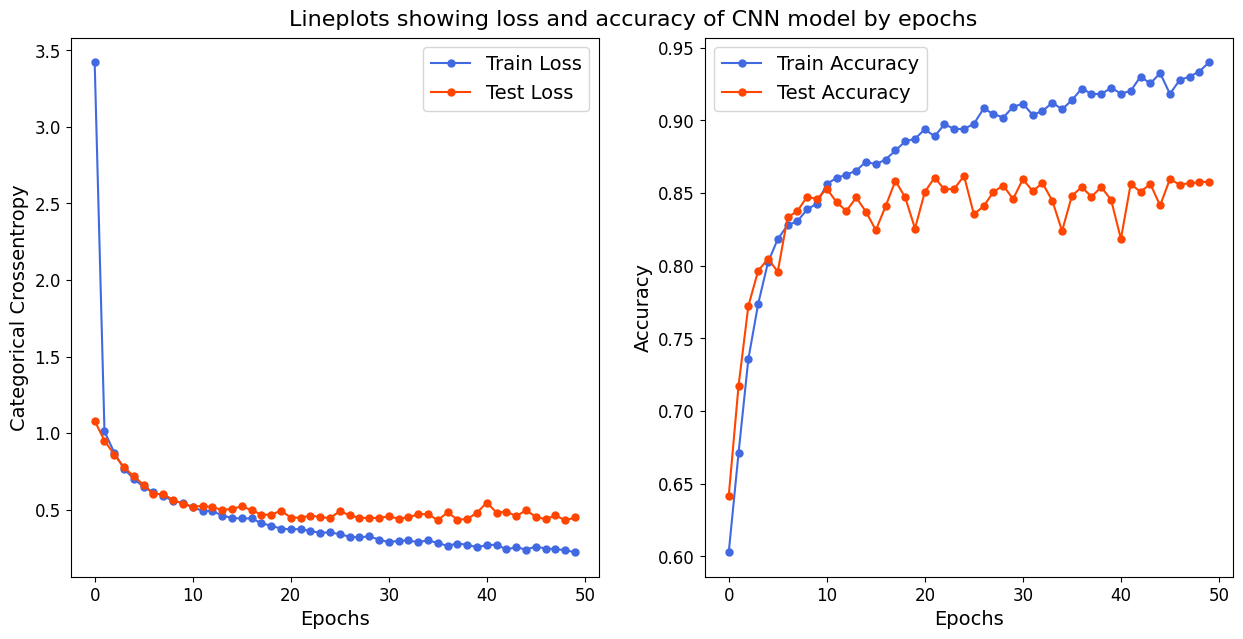

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [ ]:
!pip install opencv-python
!pip install numpy
!pip install dlib
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=c78abadf65c3643ab97df169c813f3597c044b4a3652d79935302a405fffcb36
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/output/new_gendermodel.h5')

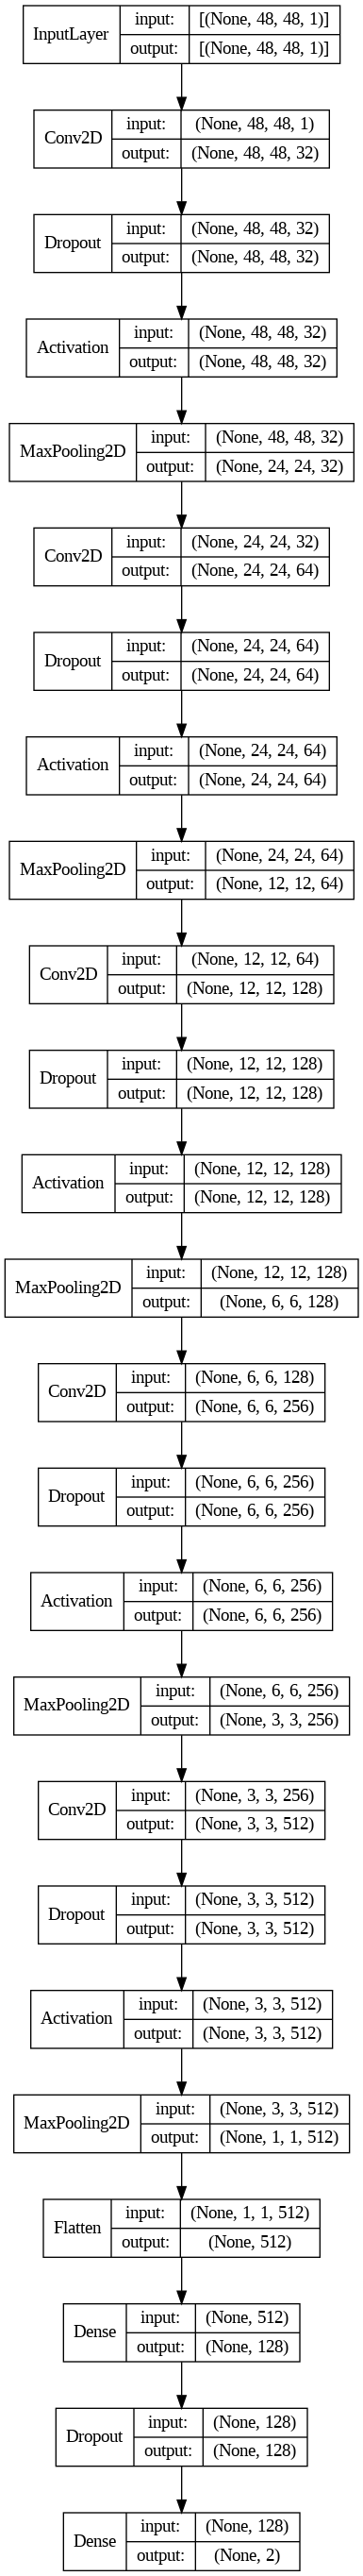

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=False)

57/57 [==============================] - 135s 2s/step


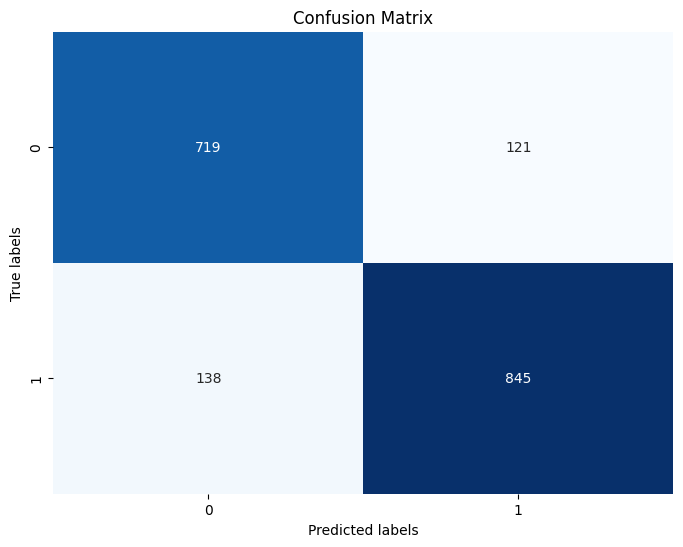

In [10]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/ProjectMajor/1.2_gender_input_output-20231228T091811Z-001/1.2_gender_input_output/output/new_gendermodel_newshape.h5')  # Assuming your model is saved as 'model.h5'

# Make predictions using the model
y_pred_prob = model.predict(x_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       840
           1       0.87      0.86      0.87       983

    accuracy                           0.86      1823
   macro avg       0.86      0.86      0.86      1823
weighted avg       0.86      0.86      0.86      1823



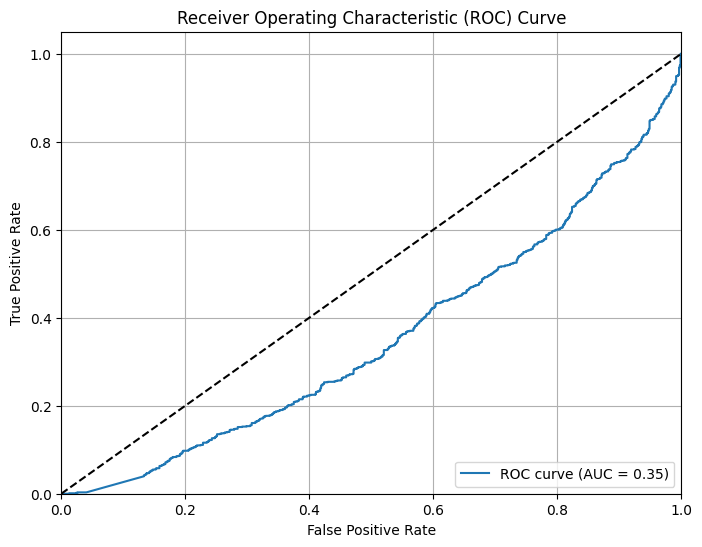

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])  # Assuming binary classification
auc = roc_auc_score(y_test, y_pred_prob[:, 1])  # Assuming binary classification

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import shutil

# Define the path to the generated file
file_path = 'model_flowchart.png'

# Define the destination path where you want to save the file
destination_path = '/content/drive/My Drive/ProjectMajor/FlowCharts2'

# Copy the file to the destination folder
shutil.copy(file_path, destination_path)

print(f"File downloaded to: {destination_path}")

File downloaded to: /content/drive/My Drive/ProjectMajor/FlowCharts2
